<a href="https://colab.research.google.com/github/hannapalya/syndromic-clustering/blob/main/MIMIC_BERT_DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import gensim.downloader as api
import pandas as pd
import numpy as np
import gensim

In [ ]:
!pip install torch==2.0.1+cu118 torchvision==0.15.2+cu118 torchaudio==2.0.2+cu118 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
!pip install transformers==4.34.0 scikit-learn==1.3.1 gdown==4.7.1


  Using cached huggingface_hub-0.17.3-py3-none-any.whl.metadata (13 kB)
Using cached huggingface_hub-0.17.3-py3-none-any.whl (295 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.26.2
    Uninstalling huggingface-hub-0.26.2:
      Successfully uninstalled huggingface-hub-0.26.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
accelerate 0.34.2 requires huggingface-hub>=0.21.0, but you have huggingface-hub 0.17.3 which is incompatible.
diffusers 0.30.3 requires huggingface-hub>=0.23.2, but you have huggingface-hub 0.17.3 which is incompatible.
sentence-transformers 3.2.1 requires huggingface-hub>=0.20.0, but you have huggingface-hub 0.17.3 which is incompatible.
sentence-transformers 3.2.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.34.0 which is incompatible.


In [ ]:
!pip install --upgrade huggingface_hub


  Using cached huggingface_hub-0.26.2-py3-none-any.whl.metadata (13 kB)
Using cached huggingface_hub-0.26.2-py3-none-any.whl (447 kB)
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.17.3
    Uninstalling huggingface-hub-0.17.3:
      Successfully uninstalled huggingface-hub-0.17.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.2.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.34.0 which is incompatible.
tokenizers 0.14.1 requires huggingface_hub<0.18,>=0.16.4, but you have huggingface-hub 0.26.2 which is incompatible.


In [ ]:
from transformers import AutoTokenizer, AutoModel

# Load ClinicalBERT from Hugging Face
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")





/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Load data

In [ ]:
dataset = pd.read_csv('triage.csv')

# Tokenize function

In [ ]:
def preprocess(text):
    inputs = tokenizer(text, return_tensors="pt")
    return inputs

## Preprocess function

In [ ]:
def get_vector(complaint):
    inputs = preprocess(complaint)
    outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    cls_embedding = cls_embedding.detach().numpy()
    return cls_embedding


## Preprocess data

In [ ]:
dataset

,subject_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint
0,10016742,33211001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PICC EVAL
1,10032725,30701739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FACIAL DROOP
2,10010867,30115213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MVC/INTUBATED TRAUMA
3,10004235,38926302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S/P ARREST
4,10027602,36678718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HEAD BLEED
...,...,...,...,...,...,...,...,...,...,...,...
217,10023239,36323598,97.7,111.0,15.0,100.0,133.0,79.0,3,3.0,"Dehydration, Nausea, Rash"
218,10039708,32345277,98.4,106.0,18.0,95.0,131.0,76.0,5,3.0,"Abd pain, Transfer"
219,10012853,35933027,96.8,78.0,16.0,95.0,186.0,66.0,8,3.0,Abd pain
220,10007795,34807453,98.6,108.0,18.0,95.0,143.0,61.0,7,3.0,"Abd pain, Back pain"


In [ ]:
X = dataset.iloc[:, [0,1,10]]

In [ ]:
cls_embeddings = [get_vector(complaint) for complaint in X.iloc[:,2]]

In [ ]:
cls_embeddings = np.vstack(cls_embeddings)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardization
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cls_embeddings)

pca = PCA()
pca.fit(scaled_data)

PCA()

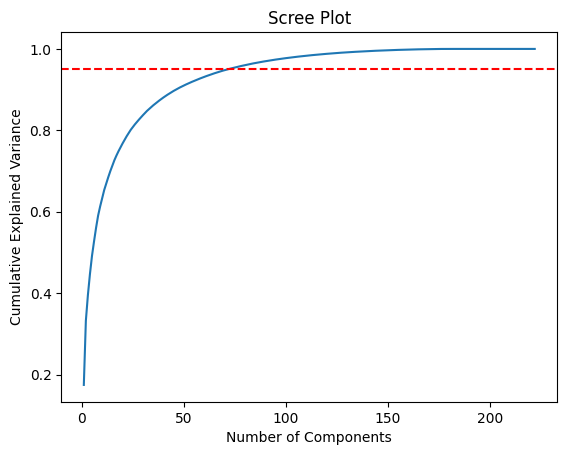

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.show()

In [ ]:
pca = PCA(n_components=70)  # e.g., 50
reduced_vectors = pca.fit_transform(scaled_data)

In [ ]:
X = X.join(pd.DataFrame(reduced_vectors))

In [ ]:
print(X)

     subject_id   stay_id             chiefcomplaint          0          1  \
0      10016742  33211001                  PICC EVAL -17.151751 -13.734442   
1      10032725  30701739               FACIAL DROOP   5.362182  -0.960611   
2      10010867  30115213       MVC/INTUBATED TRAUMA  -2.561440 -14.996935   
3      10004235  38926302                 S/P ARREST  19.352257 -15.150820   
4      10027602  36678718                 HEAD BLEED  -4.751674  -4.900377   
..          ...       ...                        ...        ...        ...   
217    10023239  36323598  Dehydration, Nausea, Rash   8.445960   3.948825   
218    10039708  32345277         Abd pain, Transfer   4.419300 -10.326614   
219    10012853  35933027                   Abd pain -11.816278  22.400557   
220    10007795  34807453        Abd pain, Back pain  -1.100461  15.274002   
221    10037928  35156583                  Back pain  -2.208054  13.252698   

             2         3         4          5          6  ...  

## Using the elbow method to find the optimal number of clusters

In [ ]:
from sklearn.neighbors import NearestNeighbors
import plotly.express as px

neighbors = 40
# X_embedded is your data
nbrs = NearestNeighbors(n_neighbors=neighbors ).fit(reduced_vectors)
distances, indices = nbrs.kneighbors(reduced_vectors)
distance_desc = sorted(distances[:,neighbors-1], reverse=True)
px.line(x=list(range(1,len(distance_desc )+1)),y= distance_desc )

In [ ]:
#!pip install kneed
from kneed import KneeLocator
kneedle = KneeLocator(range(1,len(distance_desc)+1),  #x values
                      distance_desc, # y values
                      S=0.1, #parameter suggested from paper
                      curve="convex", #parameter from figure
                      direction="decreasing",
                      online=False,
                      interp_method='polynomial',
                      polynomial_degree=15) #parameter from figure

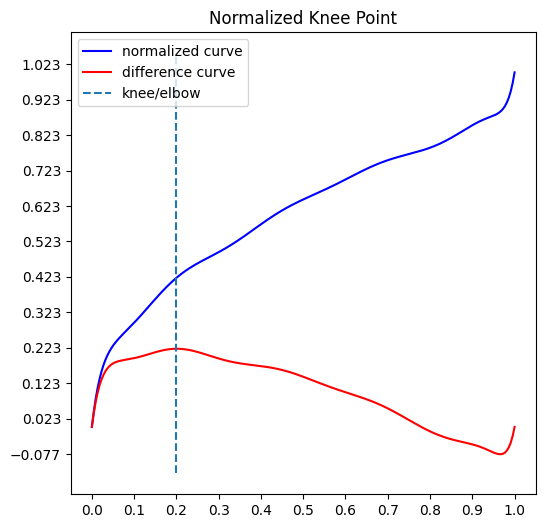

In [ ]:
kneedle.plot_knee_normalized()

In [ ]:
print(kneedle.norm_knee)

0.19909502262443438


## Training the DBSCAN model on the dataset

In [ ]:
dbscan = DBSCAN(eps=kneedle.norm_knee*80, min_samples=4)
y_dbscan= dbscan.fit_predict(reduced_vectors, y=None, sample_weight=None)

## Visualising the clusters in 2D

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Assuming X is a pandas DataFrame, convert it to a NumPy array
#X_dense = X.values

# Reduce dimensions (here using PCA for demonstration; consider t-SNE or MDS for better handling of categorical variables)
pca = PCA(n_components=2)
vectors_pca = pca.fit_transform(reduced_vectors) # Pass the dense array here

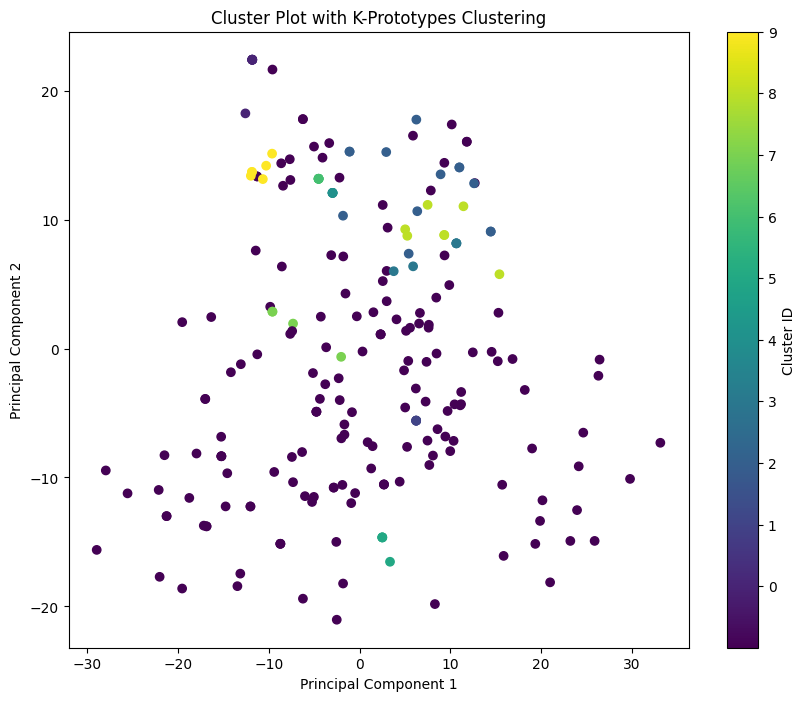

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.scatter(vectors_pca[:, 0], vectors_pca[:, 1], c=y_dbscan, cmap='viridis', label='Cluster ID')
plt.colorbar(ticks=range(25), label='Cluster ID')  # Adjust the range according to your number of clusters
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Plot with K-Prototypes Clustering')
plt.show()

## Visualising the clusters in 3D

In [ ]:
# Apply PCA to reduce dimensions to three
pca = PCA(n_components=3)
vectors_pca = pca.fit_transform(reduced_vectors)

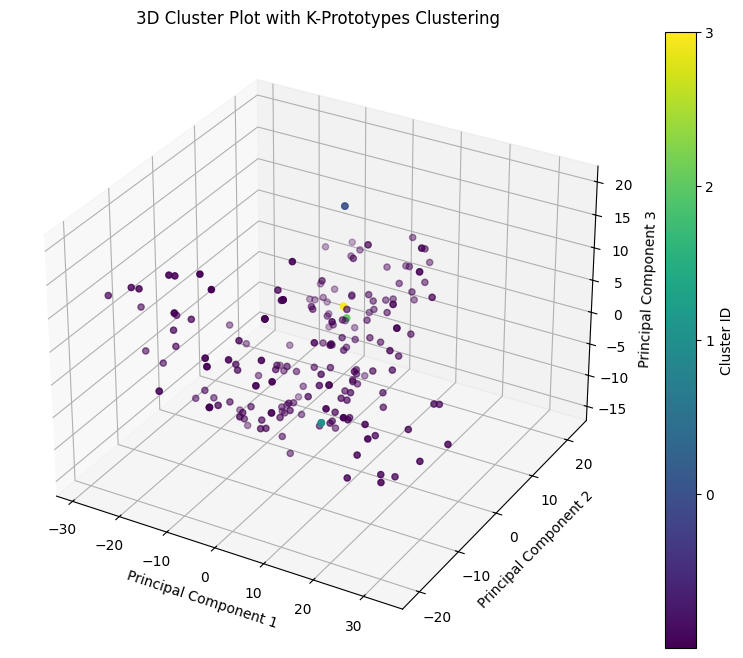

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the first three PCA components
scatter = ax.scatter(vectors_pca[:, 0], vectors_pca[:, 1], vectors_pca[:, 2], c=y_dbscan, cmap='viridis', marker='o')

# Create a color bar
colorbar = fig.colorbar(scatter, ax=ax, ticks=range(13))  # Adjust range for your number of clusters
colorbar.set_label('Cluster ID')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D Cluster Plot with K-Prototypes Clustering')

plt.show()

## Extracting what is in each cluster

In [ ]:
clustered_data = X.join(pd.DataFrame(y_dbscan, columns=['Cluster']))

In [ ]:
clustered_data

,subject_id,stay_id,chiefcomplaint,0,1,2,3,4,5,6,...,61,62,63,64,65,66,67,68,69,Cluster
0,10016742,33211001,PICC EVAL,-17.151751,-13.734442,6.297462,3.243786,-2.903642,0.466717,4.613348,...,-0.950063,1.595290,0.109111,1.541282,0.475259,1.517997,-0.057440,1.066174,0.333960,-1
1,10032725,30701739,FACIAL DROOP,5.362182,-0.960611,-10.883449,7.177662,0.586238,-1.183135,13.428957,...,0.026399,-0.787426,1.283175,1.307128,-1.336194,-1.582249,1.391476,0.705093,-1.166135,-1
2,10010867,30115213,MVC/INTUBATED TRAUMA,-2.561440,-14.996935,-2.995564,0.027206,6.645288,-10.622863,-10.231550,...,1.356428,-1.377495,-1.524869,3.521801,-0.593785,-3.502436,2.167895,1.515179,-3.820641,-1
3,10004235,38926302,S/P ARREST,19.352257,-15.150820,-7.198594,1.213248,1.200900,-11.729867,-10.642322,...,0.691389,-0.355567,-0.361234,-0.680833,1.392481,0.905423,0.629225,0.472265,-0.012430,-1
4,10027602,36678718,HEAD BLEED,-4.751674,-4.900377,-8.567364,-4.198954,-9.778792,-4.932648,5.200167,...,-0.558808,0.808550,-0.018314,0.683355,1.076688,-0.370941,-1.135800,0.814454,-0.101227,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,10023239,36323598,"Dehydration, Nausea, Rash",8.445960,3.948825,1.231336,0.639338,1.577519,8.625761,4.142391,...,0.180609,-0.361822,-0.090137,0.948155,1.521322,1.762108,-0.810122,0.079379,1.195086,-1
218,10039708,32345277,"Abd pain, Transfer",4.419300,-10.326614,19.253384,-2.197284,-2.861451,-0.146352,-1.067600,...,0.101412,0.278834,0.612870,0.574201,-0.639024,0.089314,0.144191,-0.411002,-0.768230,-1
219,10012853,35933027,Abd pain,-11.816278,22.400557,8.188933,-1.154546,-0.223574,-6.262703,-0.432219,...,0.927175,-0.364094,-0.395607,0.152627,-0.682527,-0.058485,0.407929,0.340305,0.001781,3
220,10007795,34807453,"Abd pain, Back pain",-1.100461,15.274002,7.792052,-0.921629,-1.671812,-0.481980,1.637266,...,0.335393,0.404574,0.744181,0.025630,-0.145760,0.349284,-0.047417,-0.010490,-0.533798,23


In [ ]:
clustered_data.to_csv('BERT_MIMIC_whole_clustered_dbscan_eps*80_4.csv', index=False)